### Setting up the dependencies

In [6]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
from IPython.display import clear_output

## Dataset

### Pre-processing

In [10]:
languages = []
data = []
X = []
y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

n_languages = len(languages)

In [11]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [12]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


### Test-train split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [14]:
print(X_train)

['Abashkin', 'Gulimov', 'Tzelobenok', 'Funnell', 'Zhui', 'Jukes', 'Togunov', 'Sabbag', 'Kartomyshev', 'Makhnenko', 'Sokolsky', 'Masuno', 'Varela', 'Moffat', 'Bonner', 'Berezovsky', 'Helkvist', 'Thurston', 'Tovstuha', 'Millar', 'Tulintsev', 'Furey', 'Isaenko', 'Kalachev', 'Takecare', 'Newcombe', 'Taku', 'Artibyakin', 'Saifulov', 'Morcos', 'Jagodnikov', 'Halifman', 'Bagaryakoff', 'Pavluhin', 'Mari', 'Awramchik', 'Agaltsov', 'Fisichev', 'Shizuma', 'Yankin', 'Luts', 'Toshitala', 'Germain', 'Botros', 'Poulter', 'Lischenko', 'Porter', 'Melendez', 'Ibu', 'Carr', 'Ursler', 'Aderikhin', 'Gimondi', 'Rzhevsky', 'Slater', 'Atkin', 'Yagafarov', 'Huraskin', 'Underhill', 'Pylin', 'Yuschenko', 'Ardovini', 'Tunison', 'Dobrovolsky', 'Bezyzvestnyh', 'Roussel', 'Balakshin', 'Trumbauer', 'Vallance', 'Boerio', 'Waugh', 'Baz', 'Reading', 'Komon', 'Ireson', 'Venables', 'Tikhotsky', 'Spada', 'Winfield', 'Mikhnov', 'Lubsky', 'Antar', 'Sheehan', 'Tuma', 'Yuzefovich', 'Yamburg', 'Yukhvidov', 'Mikhail', 'Chi', 'De

In [15]:
print(len(X_train), len(X_test))

16040 4010


### Encoding names and language

In [16]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [17]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1  # index = no of letters, 2nd index corresponds to batching, pos = no of chars in a word
    return rep

In [18]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long)

In [19]:
name_rep('Abreu')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [20]:
lang_rep('Portuguese')

tensor([0])

### Basic visualisation

In [21]:
count = {}
for l in languages: 
    count[l] = 0
for d in data:
    count[d[1]] += 1

In [22]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


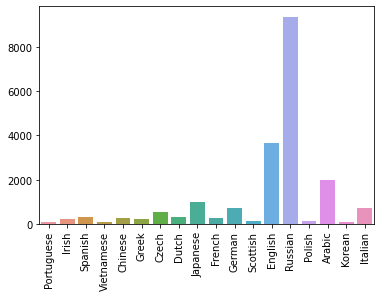

In [23]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

## Basic network and testing inference

In [24]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        # 1 -> different chars, 2-> batch size i.e. different words, 3rd -> hidden_size
        return torch.zeros(1, batch_size, self.hidden_size)

In [25]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)

In [26]:
def infer(net, name, device = 'cpu'):
    name_ohe = name_rep(name).to(device)
    
    output, hidden = net(name_ohe)
        
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    
    return output

In [27]:
infer(net, 'Adam')

tensor([[-2.9741, -2.7816, -2.9944, -2.9997, -2.9431, -2.8269, -2.8659, -2.9512,
         -2.8654, -2.8162, -2.9460, -2.8492, -2.9538, -2.8603, -2.8542, -2.9259,
         -2.7560, -2.9076]], grad_fn=<LogSoftmaxBackward>)

## Evaluate model

In [28]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [29]:
dataloader(2, X_train, y_train)

[('Hatagov',
  'Russian',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [30]:
def eval(net, n_points, topk, X_, y_, device = 'cpu'):
    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name, device)
        val, indices = output.topk(topk)
        indices = indices.to('cpu')
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [31]:
eval(net, 1000, 1, X_test, y_test)

0.012

# Batching

***Batching is of 2 types :*** 
* Vectorization : performing larger vectors and work parallely. This brings imporvement in performance.
* Aggregated Gradients Computation : Reduces variance in parameter updates. Gradient computation is done for multiple data items and aggregated, then 1 update is done.


In [32]:
def batched_name_rep(names, max_word_size):
    # A list of names(total names = batch_size) with the length of the largest name is passed.
    rep = torch.zeros(max_word_size, len(names), n_letters)
    
    for name_index, name in enumerate(names):               # Go through each name.
        for letter_index, letter in enumerate(name):        # Go through each letter.
            pos = all_letters.find(letter)                  # Find the position of the letter in a list of all_letters.
            rep[letter_index][name_index][pos] = 1          # Watch the video for the representation!
            # Pad is represented by 0 in rep tensor.
    return rep

In [33]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))  # Reshaping to have l_index* n_index, pos size.
    for t in name_reps:
        if torch.sum(t) == 0:
            print('<pad>')                                 
        else:
            index = t.argmax()
            print(all_letters[index])

In [34]:
out_ = batched_name_rep( ('Shyam', 'Ram'), 5)
print(out_)
print(out_.shape)
print_char(out_)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0

In [35]:
def batched_lang_rep(langs):
    rep = torch.zeros( [len(langs)], dtype = torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep

Getting a packed tensor.

In [36]:
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []

    # For a specified no of points, going through the data for names and languages with a random index index and appending them in names and langs list.
    for i in range(npoints):       
        index = np.random.randint(npoints)
        name, lang = X_[index], y_[index]
        X_lengths.append( len(name) )    # Appending the length of each name.
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)         # Getting the max length.

    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)

    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted= False)

    if verbose:
        print( names_rep.shape, padded_names_rep.data.shape)
        print("---")
    
    if verbose:
        print( names)
        print_char(names_rep)
        print("---")

    if verbose:
        print_char(padded_names_rep.data)
        print("Lang Rep", langs_rep.data)
        print("Batch Size", padded_names_rep.batch_sizes)
        print("---")
    
    return padded_names_rep.to(device), langs_rep

In [37]:
p, l = batched_dataloader(3, X_train, y_train, True)

torch.Size([10, 3, 57]) torch.Size([25, 57])
---
['Gulimov', 'Tzelobenok', 'Abashkin']
G
T
A
u
z
b
l
e
a
i
l
s
m
o
h
o
b
k
v
e
i
<pad>
n
n
<pad>
o
<pad>
<pad>
k
<pad>
---
T
A
G
z
b
u
e
a
l
l
s
i
o
h
m
b
k
o
e
i
v
n
n
o
k
Lang Rep tensor([13, 13, 13])
Batch Size tensor([3, 3, 3, 3, 3, 3, 3, 2, 1, 1])
---


## Training

### Basic setup

In [38]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [39]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    net.to(device)

    opt.zero_grad()

    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)

    output, hidden = net(batch_input)

    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [40]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [41]:
%%time 
train(net, opt, criterion, 256)

CPU times: user 502 ms, sys: 6.77 ms, total: 509 ms
Wall time: 516 ms


tensor(2.8740, grad_fn=<DivBackward0>)

In [42]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [43]:
%%time 
train_batch(net, opt, criterion, 256)

CPU times: user 28.5 ms, sys: 5.64 ms, total: 34.1 ms
Wall time: 55.9 ms


tensor(2.8885, grad_fn=<NllLossBackward>)

### Full training setup

In [44]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test, device))
                      

## RNN Cell

Iteration 4999 Loss 0.024344883859157562


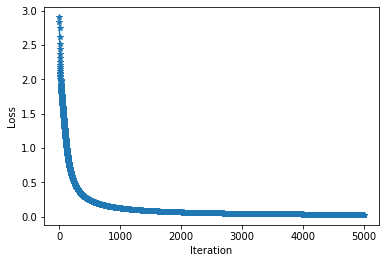




Top-1: 0.543640897755611 Top-2: 0.6538653366583541
CPU times: user 4min 31s, sys: 2.71 s, total: 4min 34s
Wall time: 4min 34s


In [45]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=500) # CPU Training example

Iteration 4999 Loss 0.02388673834502697


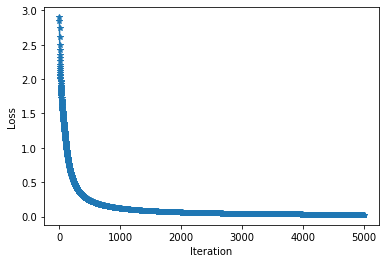




Top-1: 0.5521197007481297 Top-2: 0.6673316708229426
CPU times: user 2min 59s, sys: 2.36 s, total: 3min 2s
Wall time: 3min 7s


In [46]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=100, device = device_gpu) # GPU Training Example

## LSTM cell

In [47]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.lstm_cell(input, hidden)
        output = self.h2o(hidden[0].view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

Iteration 7999 Loss 0.05890139564871788


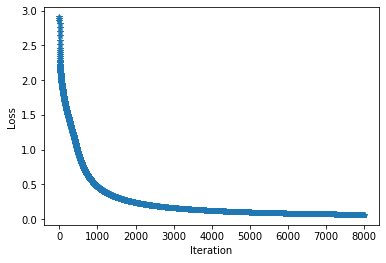




Top-1: 0.6112219451371571 Top-2: 0.7119700748129676


In [48]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)

## GRU Cell

In [49]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.gru_cell(input, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

Iteration 7999 Loss 0.042368970811367035


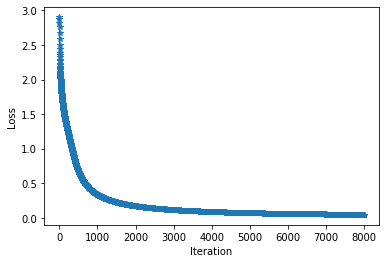




Top-1: 0.6047381546134664 Top-2: 0.7074812967581048


In [50]:
n_hidden = 128
net = GRU_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)